## Problem Statement

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

You can get the dataset here https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/

It is advised to look at the dataset after completing the hypothesis generation part.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error 
from math import sqrt

# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
# import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
# from statsmodels.tsa.stattools import acf, pacf 
# from statsmodels.tsa.arima_model import ARIMA
# import statsmodels.api as sm

from fbprophet import Prophet

pd.plotting.register_matplotlib_converters() 

## Import data

In [2]:
train = pd.read_csv('../input_files/train_dataset.csv') 
test = pd.read_csv('../input_files/test_dataset.csv')

In [3]:
train_original = train.copy() 
test_original = test.copy()

In [4]:
print('Train dataset columns:\n'+str(train.columns)+'\n----------------------------------------------------')
print('Test dataset columns:\n'+str(test.columns))

Train dataset columns:
Index(['ID', 'Datetime', 'Count'], dtype='object')
----------------------------------------------------
Test dataset columns:
Index(['ID', 'Datetime'], dtype='object')


In [5]:
print('Train dataset dtypes:\n'+str(train.dtypes)+'\n------------------------')
print('Test dataset dtypes:\n'+str(test.dtypes))

Train dataset dtypes:
ID           int64
Datetime    object
Count        int64
dtype: object
------------------------
Test dataset dtypes:
ID           int64
Datetime    object
dtype: object


In [6]:
print('Train dataset shape:\n'+str(train.shape)+'\n----------------------------')
print('Test dataset shape:\n'+str(test.shape))

Train dataset shape:
(18288, 3)
----------------------------
Test dataset shape:
(5112, 2)


In [7]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M') 

test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')

In [8]:
for i in (train, test, test_original, train_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour

In [9]:
train['day_of_week'] = train['Datetime'].dt.dayofweek

temp = train['Datetime']

In [10]:
train.head()

ID            Datetime  Count  year  month  day  Hour  day_of_week
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5
3   3 2012-08-25 03:00:00      2  2012      8   25     3            5
4   4 2012-08-25 04:00:00      2  2012      8   25     4            5

In [11]:
train['weekend'] = np.where(train['day_of_week'] > 4, 1, 0)

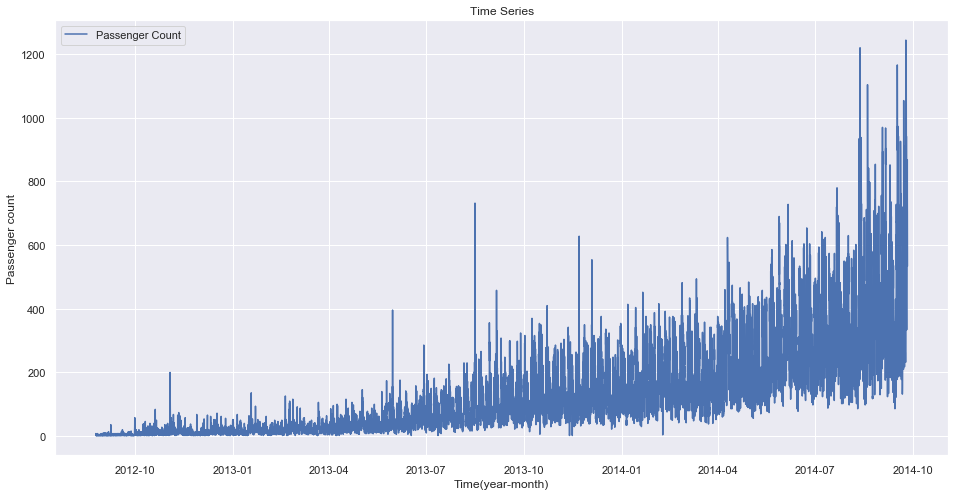

In [12]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df = train.drop('ID', 1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 

plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best');

Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

In [13]:
df.head()

Datetime  Count  year  month  day  Hour  \
Datetime                                                                 
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

In [14]:
train.head()

ID            Datetime  Count  year  month  day  Hour  \
Datetime                                                                     
2012-08-25 00:00:00   0 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00   1 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00   2 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00   3 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00   4 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

## Hypotheses

We will start with the first step, i.e. Hypothesis Generation. Hypothesis Generation is the process of listing out all the possible factors that can affect the outcome.

Hypothesis generation is done before having a look at the data in order to avoid any bias that may result after the observation.

Hypothesis Generation

Hypothesis generation helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

 - There will be an increase in the traffic as the years pass by.

Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.

- The traffic will be high from May to October.

Explanation - Tourist visits generally increases during this time perion.

- Traffic on weekdays will be more as compared to weekends/holidays.

Explanation - People will go to office on weekdays and hence the traffic will be more

- Traffic during the peak hours will be high.

Explanation - People will travel to work, college.

We will try to validate each of these hypothesis based on the dataset. Now let’s have a look at the dataset.

- H1: Traffic will increase as the years pass by

In [15]:
df_mean_traffic = train.groupby(['year'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

In [16]:
df_mean_traffic

year  mean_traffic
0  2012     11.282946
1  2013     78.306849
2  2014    283.017102

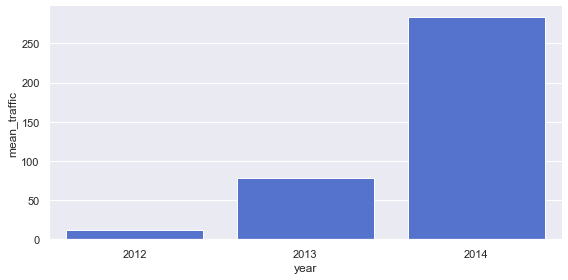

In [17]:
g = sns.catplot(x='year',y="mean_traffic", kind='bar', data=df_mean_traffic, height=4, aspect=2, color='royalblue');

In [18]:
# train.groupby('year')['Count'].mean().plot.bar();

We see an exponential growth in the traffic with respect to year which validates our hypothesis.

- H2: Traffic will be high from May to October

In [19]:
df_mean_traffic_month = train.groupby(['month'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

In [20]:
df_mean_traffic_month

month  mean_traffic
0       1     92.817204
1       2    111.196429
2       3    103.791667
3       4    137.680556
4       5    155.055108
5       6    186.723611
6       7    209.071237
7       8    220.497585
8       9    181.958824
9      10     75.459677
10     11     78.413889
11     12     86.533602

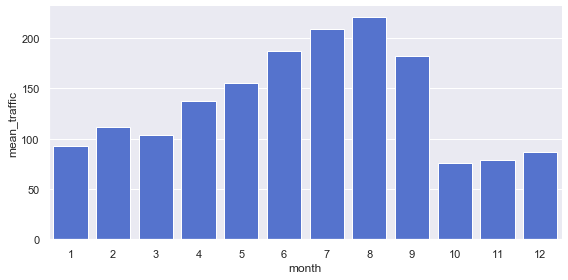

In [21]:
g = sns.catplot(x='month',y="mean_traffic", kind='bar', data=df_mean_traffic_month, height=4, aspect=2, color='royalblue');

In [22]:
# train.groupby('month')['Count'].mean().plot.bar();

In [23]:
df_mean_traffic_year_month = train.groupby(['year','month'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

In [24]:
df_mean_traffic_year_month.head()

year  month  mean_traffic
0  2012      8      2.952381
1  2012      9      4.444444
2  2012     10     10.986559
3  2012     11     15.827778
4  2012     12     15.680108

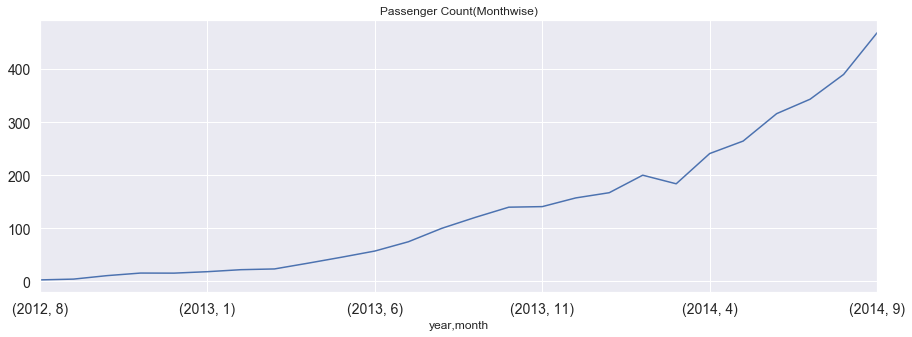

In [25]:
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14);

In [26]:
temp.index[0], temp.index[-1]

((2012, 8), (2014, 9))

- We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.
- Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.

- In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.



Let’s look at the daily mean of passenger count.

In [27]:
df_mean_traffic_day = train.groupby(['day'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

In [28]:
df_mean_traffic_day.head()

day  mean_traffic
0    1    129.256667
1    2    133.830000
2    3    135.906667
3    4    142.310000
4    5    149.976667

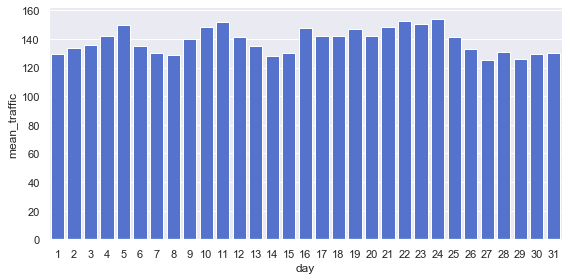

In [29]:
g = sns.catplot(x='day',y="mean_traffic", kind='bar', data=df_mean_traffic_day, height=4, aspect=2, color='royalblue');

We are not getting much insights from day wise count of the passengers.

In [30]:
# train.groupby('day')['Count'].mean().plot.bar()

- H3: Traffic on weekdays will be more

In [31]:
df_mean_traffic_weekend = train.groupby(['weekend'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

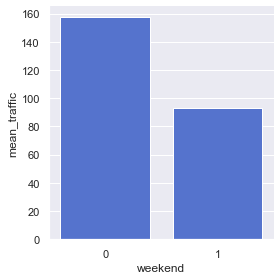

In [32]:
g = sns.catplot(x='weekend',y="mean_traffic", kind='bar', data=df_mean_traffic_weekend, 
                height=4, aspect=1, color='royalblue');

In [33]:
df_mean_traffic_week = train.groupby(['day_of_week'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

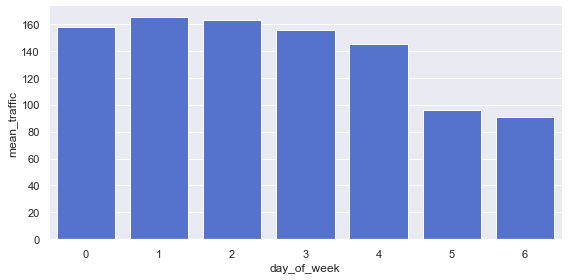

In [34]:
g = sns.catplot(x='day_of_week',y="mean_traffic", kind='bar', data=df_mean_traffic_week, 
                height=4, aspect=2, color='royalblue');

From the above bar plot, we can infer that the passenger count is less for Saturday and Sunday as compared to the other days of the week.

In [35]:
# train.groupby('day of week')['Count'].mean().plot.bar()

- H4: Traffic during the peak hours will be high

In [36]:
df_mean_traffic_hour = train.groupby(['Hour'], as_index=False)['Count'].mean().rename(index=str, columns={'Count': 'mean_traffic'})

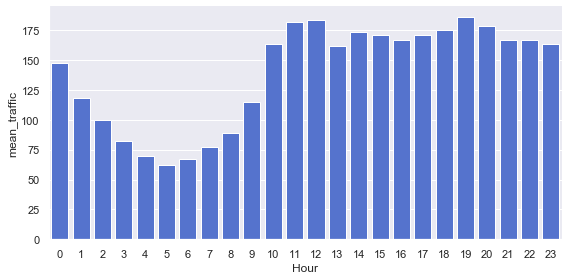

In [37]:
g = sns.catplot(x='Hour',y="mean_traffic", kind='bar', data=df_mean_traffic_hour, 
                height=4, aspect=2, color='royalblue');

It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.

After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

In [38]:
train = train.drop('ID', axis=1)

In [39]:
train.head()

Datetime  Count  year  month  day  Hour  \
Datetime                                                                 
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   

                     day_of_week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [40]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

In [41]:
# pd.plotting.register_matplotlib_converters() 

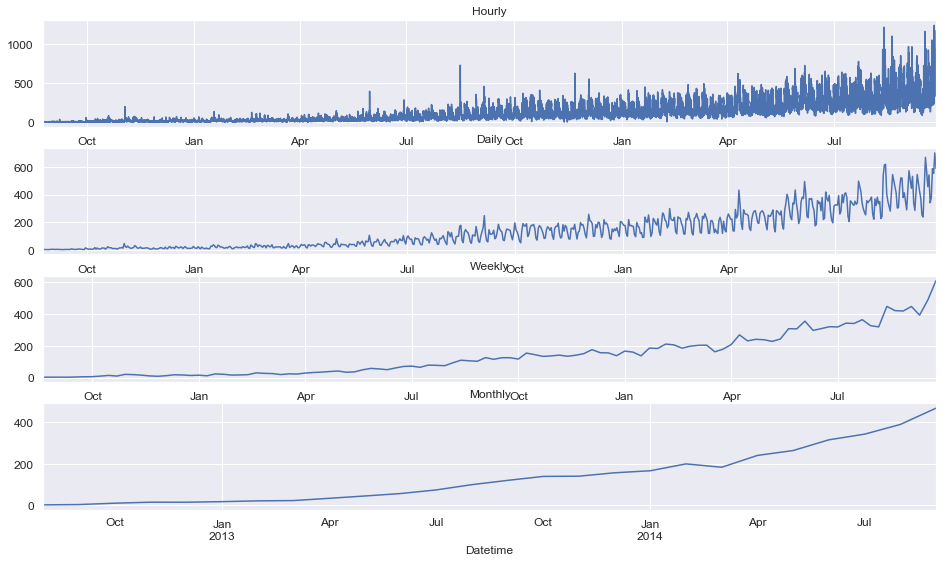

In [42]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(16,9), title= 'Hourly', fontsize=12, ax=axs[0]);
daily.Count.plot(figsize=(16,9), title= 'Daily', fontsize=12, ax=axs[1]);
weekly.Count.plot(figsize=(16,9), title= 'Weekly', fontsize=12, ax=axs[2]); 
monthly.Count.plot(figsize=(16,9), title= 'Monthly', fontsize=12, ax=axs[3]); 

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.
But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [43]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

As we have validated all our hypothesis, let’s go ahead and build models for Time Series Forecasting. But before we do that, we will need a dataset (validation) to check the performance and generalisation ability of our model. Below are some of the properties of the dataset required for the purpose.

- The dataset should have the true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.

- The model should not be trained on the validation dataset. Hence, we cannot train the model on the train dataset and validate on it as well.

So, for the above two reasons, we generally divide the train dataset into two parts. One part is used to train the model and the other part is used as the validation dataset. Now there are multiple ways to divide the train dataset such as Random Division etc. You can look for all of the different validation methods here: https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/.

For this course, We will be using a time based split explained below.

## Splitting data into training and validation part

Now we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

NOTE - It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric (rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [44]:
Train=train.loc['2012-08-25':'2014-06-24'] 
valid=train.loc['2014-06-25':'2014-09-25']

In [45]:
Train.head()

Count    year  month   day  Hour  day_of_week  weekend
Datetime                                                             
2012-08-25  3.166667  2012.0    8.0  25.0  11.5          5.0      1.0
2012-08-26  3.666667  2012.0    8.0  26.0  11.5          6.0      1.0
2012-08-27  2.583333  2012.0    8.0  27.0  11.5          0.0      0.0
2012-08-28  2.416667  2012.0    8.0  28.0  11.5          1.0      0.0
2012-08-29  2.500000  2012.0    8.0  29.0  11.5          2.0      0.0

In [46]:
valid.head()

Count    year  month   day  Hour  day_of_week  weekend
Datetime                                                               
2014-06-25  353.666667  2014.0    6.0  25.0  11.5          2.0      0.0
2014-06-26  395.250000  2014.0    6.0  26.0  11.5          3.0      0.0
2014-06-27  282.333333  2014.0    6.0  27.0  11.5          4.0      0.0
2014-06-28  218.250000  2014.0    6.0  28.0  11.5          5.0      1.0
2014-06-29  196.250000  2014.0    6.0  29.0  11.5          6.0      1.0

- We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

- Let\'s understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

Now we will look at how the train and validation part has been divided.

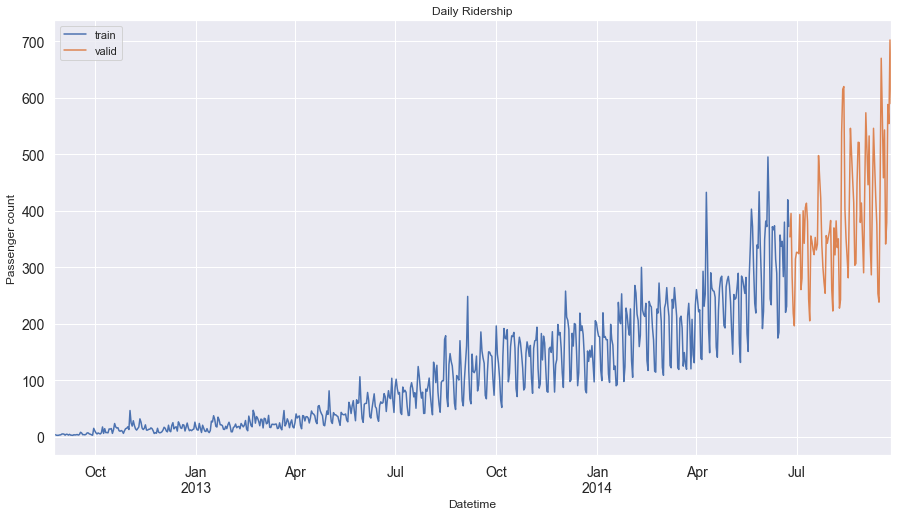

In [47]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best'); 
# plt.show()

Here the blue part represents the train data and the orange part represents the validation data.

We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.

### Stationarity Check
- We use Dickey Fuller test to check the stationarity of the series.
- The intuition behind this test is that it determines how strongly a time series is defined by a trend.
- The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
- The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

Let’s make a function which we can use to calculate the results of Dickey-Fuller test.

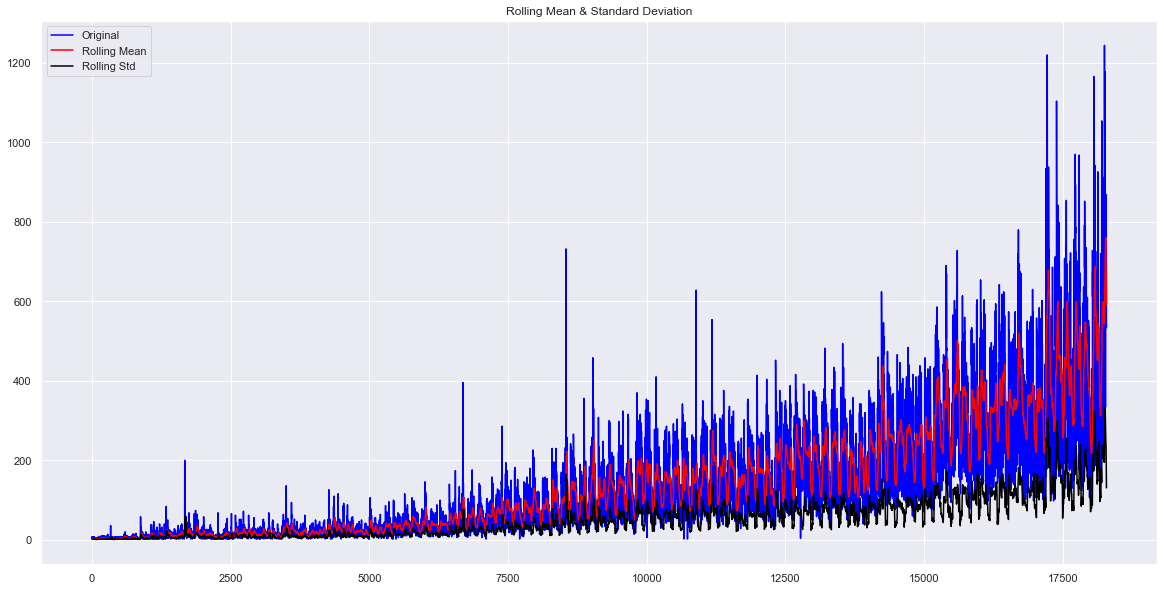

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [48]:
# from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
        #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
        #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

The statistics shows that the time series is stationary as Test Statistic < Critical value but we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the trend and seasonality from the data.

#### Removing trend
- A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.
- We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.
- We will take rolling average here to remove the trend. We will take the window size of 24 based on the fact that each day has 24 hours.

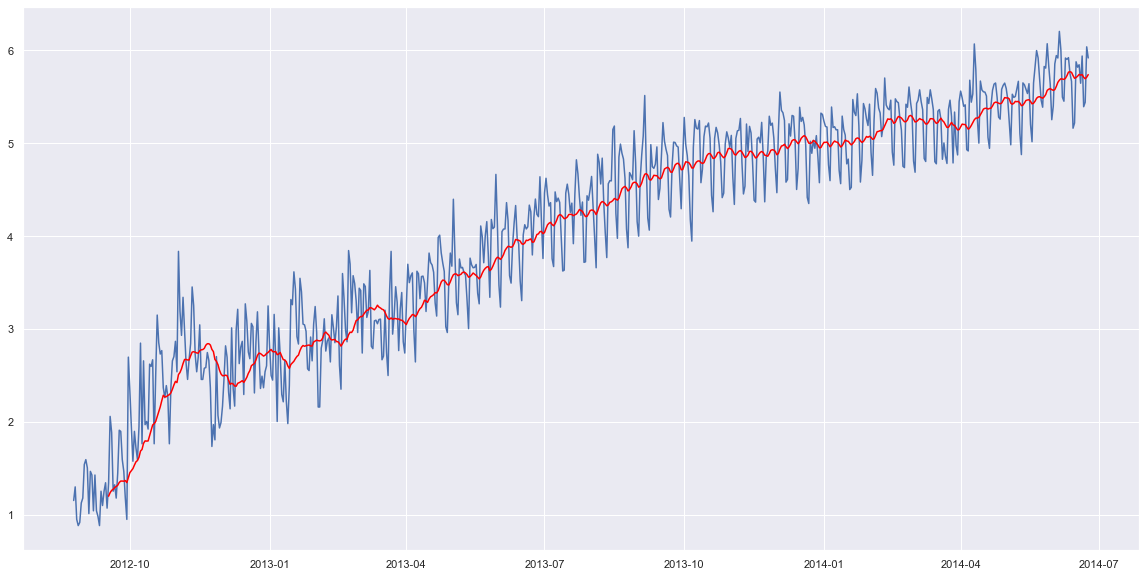

In [49]:
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean()

plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [50]:
train_log_moving_avg_diff = Train_log - moving_avg

Since we took the average of 24 values, rolling mean is not defined for the first 23 values. So let’s drop those null values.

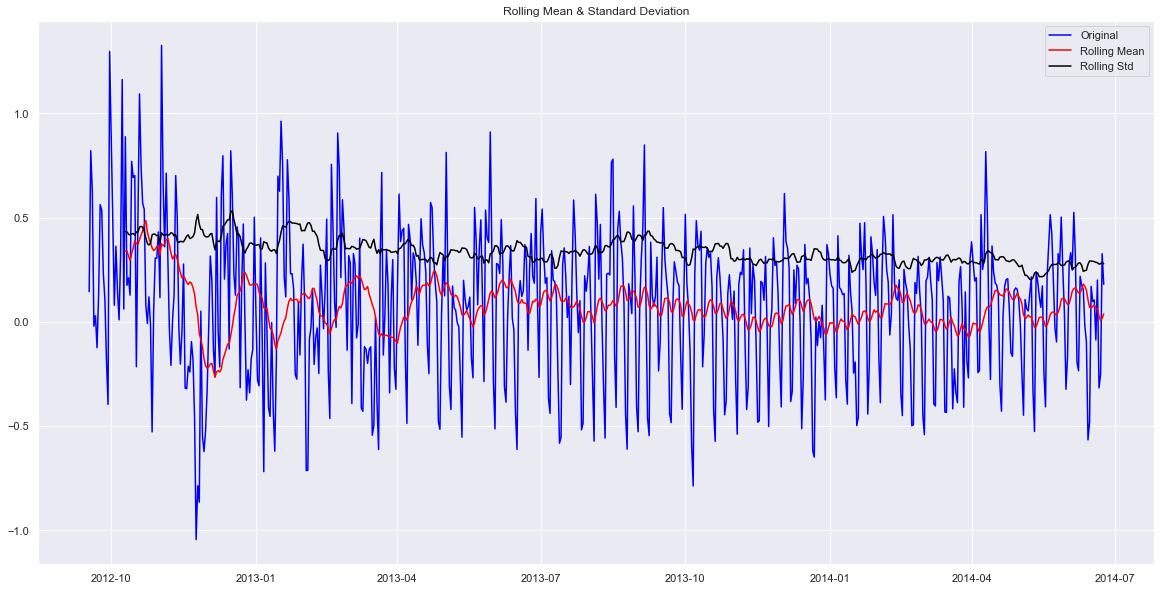

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [51]:
train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

We can see that the Test Statistic is very smaller as compared to the Critical Value. So, we can be confident that the trend is almost removed.

Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.

- Differencing can help to make the series stable and eliminate the trend.

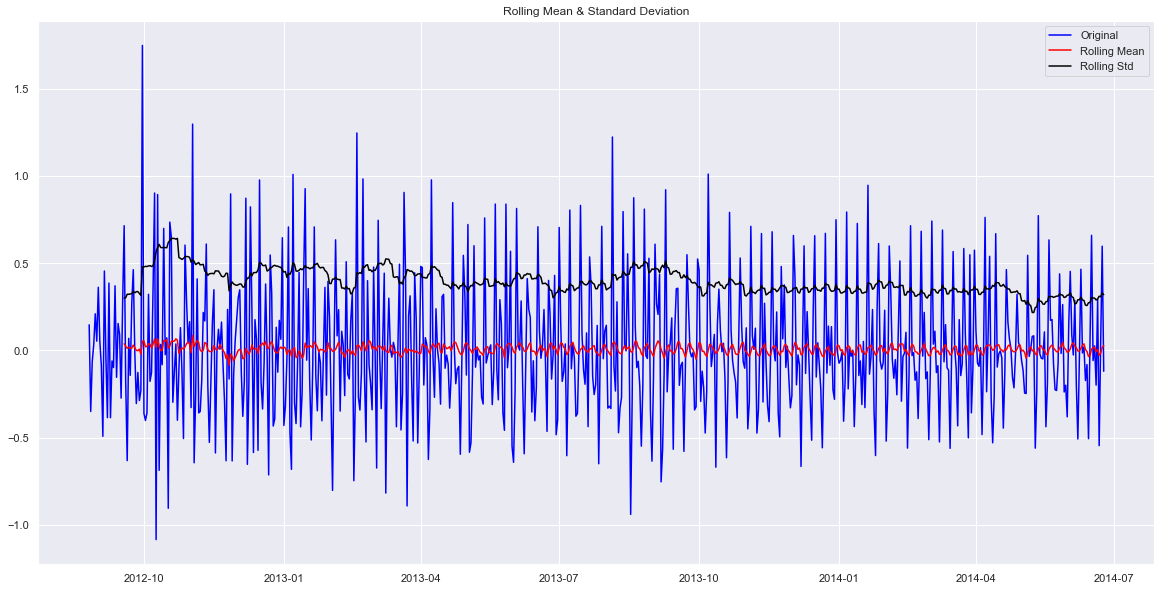

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [52]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

Now we will decompose the time series into trend and seasonality and will get the residual which is the random variation in the series.

#### Removing Seasonality
- By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
- Seasonality is always of a fixed and known period.
- We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.

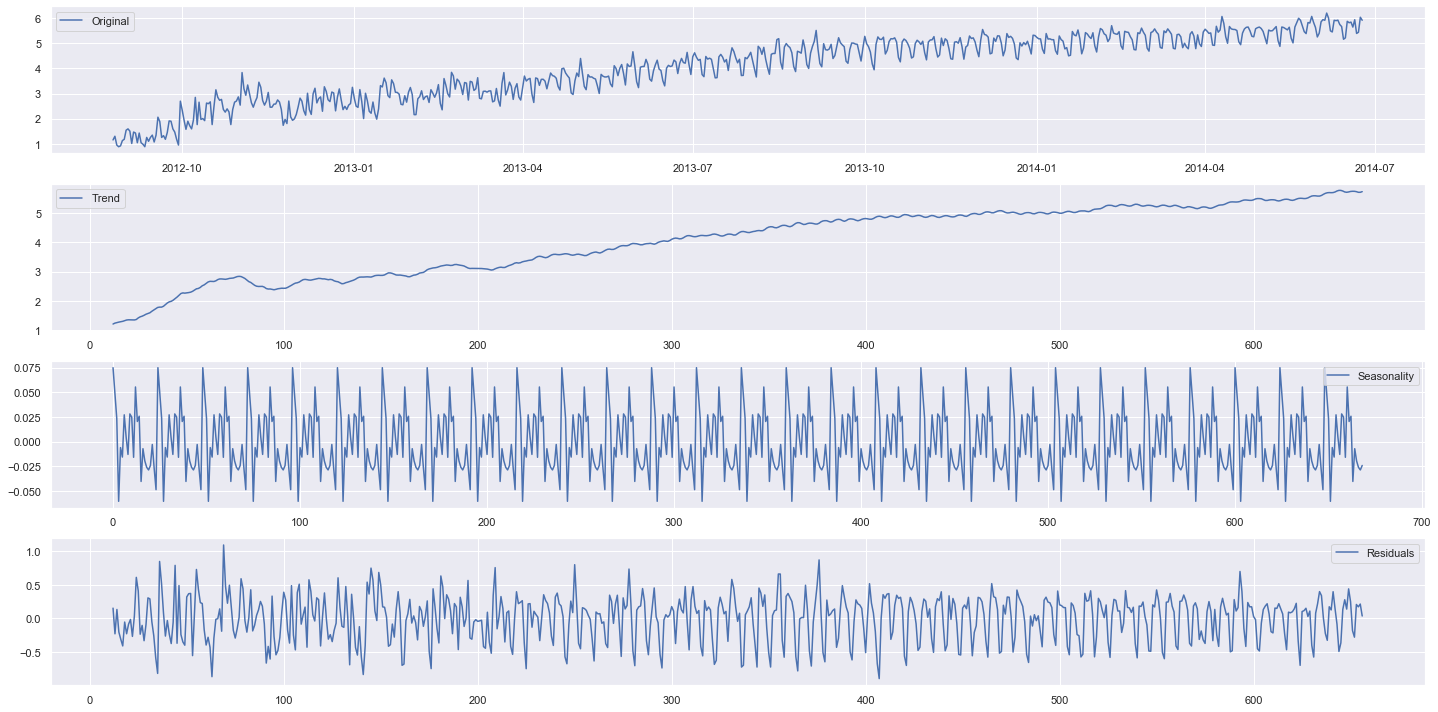

In [53]:
# from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best')

plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 

plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 

plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

We can see the trend, residuals and the seasonality clearly in the above graph. Seasonality shows a constant trend in counter.

Let’s check stationarity of residuals.

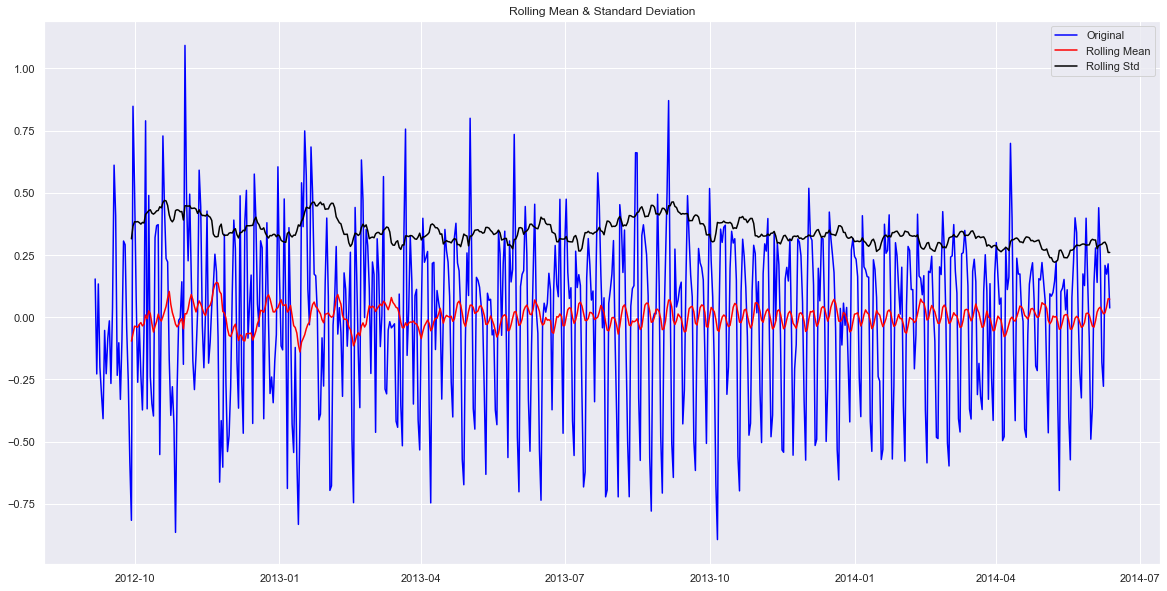

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [54]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = Train_log.index 
train_log_decompose.set_index('date', inplace = True) 
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose[0])

## Modeling Techniques

### FB Prophet

- Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
- It works best with time series that have strong seasonal effects and several seasons of historical data. 
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- FB Prophet is designed to work best on a daily level predictions, but it can also work on other levels.

In [55]:
Train['log_count'] = np.log(Train['Count']) 
Train['ds'] = Train.index
Train.rename(index=str, columns={'log_count':'y'}, inplace=True)

In [56]:
Train.head()

Count    year  month   day  Hour  day_of_week  \
Datetime                                                                
2012-08-25 00:00:00  3.166667  2012.0    8.0  25.0  11.5          5.0   
2012-08-26 00:00:00  3.666667  2012.0    8.0  26.0  11.5          6.0   
2012-08-27 00:00:00  2.583333  2012.0    8.0  27.0  11.5          0.0   
2012-08-28 00:00:00  2.416667  2012.0    8.0  28.0  11.5          1.0   
2012-08-29 00:00:00  2.500000  2012.0    8.0  29.0  11.5          2.0   

                     weekend         y         ds  
Datetime                                           
2012-08-25 00:00:00      1.0  1.152680 2012-08-25  
2012-08-26 00:00:00      1.0  1.299283 2012-08-26  
2012-08-27 00:00:00      0.0  0.949081 2012-08-27  
2012-08-28 00:00:00      0.0  0.882389 2012-08-28  
2012-08-29 00:00:00      0.0  0.916291 2012-08-29

In [57]:
model = Prophet(growth='linear', yearly_seasonality=True, daily_seasonality=True)
model.add_country_holidays(country_name='US')

In [58]:
model.fit(Train)

In [59]:
Train.shape, valid.shape

((669, 9), (93, 7))

In [60]:
future = model.make_future_dataframe(periods=93)

In [61]:
forecast = model.predict(future)

In [62]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(2)

ds      yhat  yhat_lower  yhat_upper
0 2012-08-25  0.998266    0.640496    1.345171
1 2012-08-26  0.952256    0.603082    1.271886

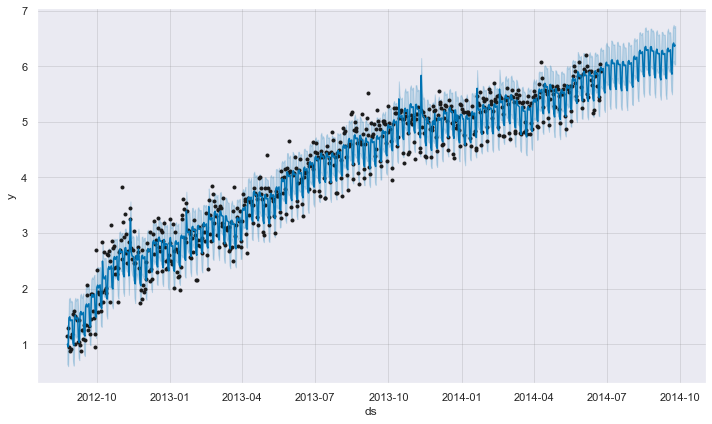

In [63]:
fig1 = model.plot(forecast)

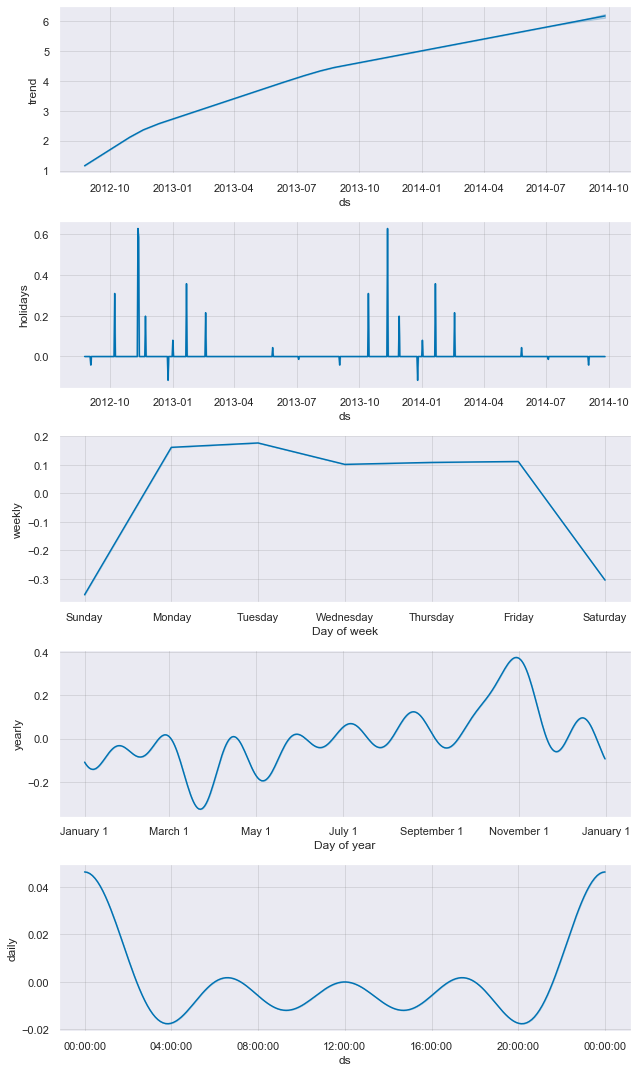

In [64]:
fig2 = model.plot_components(forecast)

In [65]:
# Python
from fbprophet.plot import plot_plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()

fig = plot_plotly(model, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [66]:
valid.head(1)

Count    year  month   day  Hour  day_of_week  weekend
Datetime                                                               
2014-06-25  353.666667  2014.0    6.0  25.0  11.5          2.0      0.0

In [67]:
valid.tail(1)

Count    year  month   day  Hour  day_of_week  weekend
Datetime                                                               
2014-09-25  589.666667  2014.0    9.0  25.0  11.5          3.0      0.0

In [68]:
valid.reset_index(inplace=True)

In [69]:
# valid hat
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(93)

In [70]:
predictions.head(1)

ds      yhat  yhat_lower  yhat_upper
669 2014-06-25  5.928091     5.59933    6.276565

In [71]:
predictions.tail(1)

ds      yhat  yhat_lower  yhat_upper
761 2014-09-25  6.381911    6.031712    6.726309

In [72]:
predictions.ds = pd.to_datetime(predictions.ds)

In [73]:
predictions.head(2)

ds      yhat  yhat_lower  yhat_upper
669 2014-06-25  5.928091    5.599330    6.276565
670 2014-06-26  5.947428    5.600561    6.301502

In [74]:
final_data = valid.merge(predictions, left_on='Datetime', right_on='ds')

In [75]:
final_data.yhat = np.exp(final_data['yhat']) 
final_data.yhat_lower = np.exp(final_data['yhat_lower']) 
final_data.yhat_upper = np.exp(final_data['yhat_upper']) 

In [76]:
final_data.head(2)

Datetime       Count    year  month   day  Hour  day_of_week  weekend  \
0 2014-06-25  353.666667  2014.0    6.0  25.0  11.5          2.0      0.0   
1 2014-06-26  395.250000  2014.0    6.0  26.0  11.5          3.0      0.0   

          ds        yhat  yhat_lower  yhat_upper  
0 2014-06-25  375.437298  270.245345  531.958097  
1 2014-06-26  382.767720  270.578282  545.390229

In [77]:
final_data.dtypes

Datetime       datetime64[ns]
Count                 float64
year                  float64
month                 float64
day                   float64
Hour                  float64
day_of_week           float64
weekend               float64
ds             datetime64[ns]
yhat                  float64
yhat_lower            float64
yhat_upper            float64
dtype: object

In [78]:
final_data.index = final_data.Datetime

In [79]:
final_data = final_data[['Count', 'yhat', 'yhat_lower', 'yhat_upper']]

In [80]:
final_data.head()

Count        yhat  yhat_lower  yhat_upper
Datetime                                                  
2014-06-25  353.666667  375.437298  270.245345  531.958097
2014-06-26  395.250000  382.767720  270.578282  545.390229
2014-06-27  282.333333  388.827527  278.138904  544.328278
2014-06-28  218.250000  259.762237  185.234580  369.859893
2014-06-29  196.250000  249.687680  177.610322  349.151474

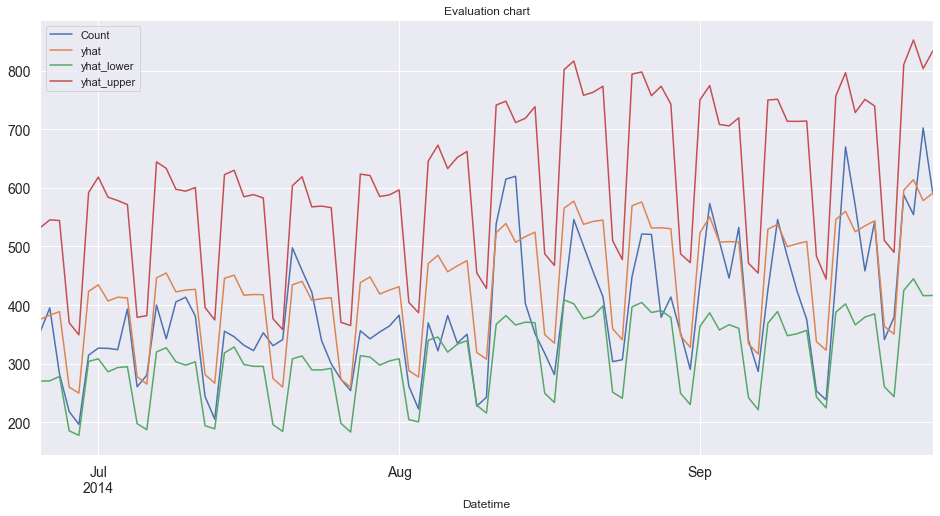

In [81]:
final_data.Count.plot(figsize=(16, 8), fontsize=14 , label='count')
final_data.yhat.plot(figsize=(16, 8), fontsize=14 , label='predicted')
final_data.yhat_lower.plot(figsize=(16, 8), fontsize=14 , label='predicted_lower')
final_data.yhat_upper.plot(figsize=(16, 8), fontsize=14 , label='predicted_upper')
plt.legend(final_data.columns.values, loc='best');
plt.title('Evaluation chart');

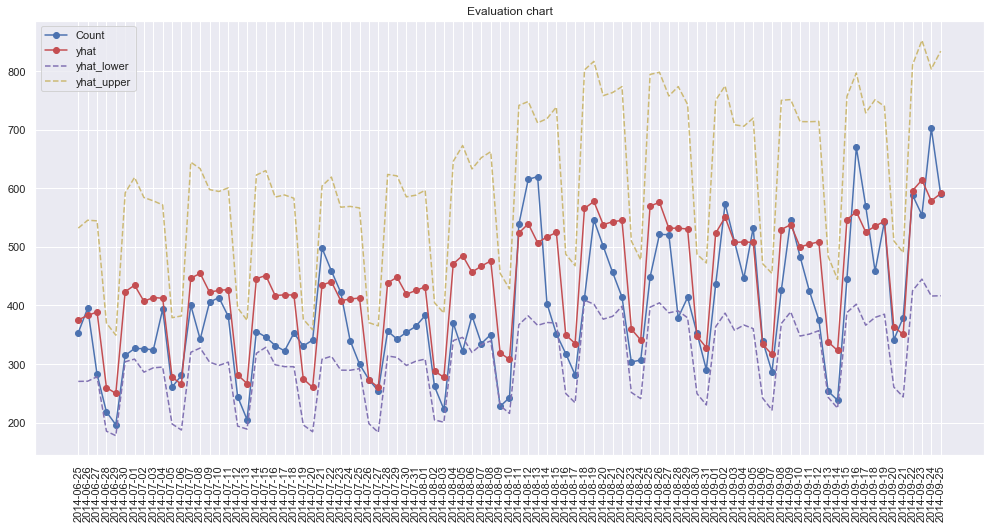

In [82]:
plt.figure(figsize=(17,8));
plt.plot(final_data.index, final_data.Count.values, 'o-b');
plt.plot(final_data.index, final_data.yhat.values, 'o-r');
plt.plot(final_data.index, final_data.yhat_lower.values, '--m')
plt.plot(final_data.index, final_data.yhat_upper.values, '--y')
plt.xticks(final_data.index, final_data.index.astype(str).values, rotation=90)
plt.legend(final_data.columns.values, loc='best');
plt.title('Evaluation chart');

In [83]:
rmse = np.round(sqrt(mean_squared_error(final_data.yhat, final_data.Count )), 2)
print(rmse)

77.6
